Importing all the required libraries

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
import string
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,classification_report, recall_score



In [2]:
file_path = r'D:\VS Code Folders\CODSOFT\Spam SMS Detection\sms spam dataset\spam.csv'

try:
    df = pd.read_csv(file_path)
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='latin1')

df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Performing EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
df.shape

(5572, 5)

In [5]:
df.drop(columns = ['Unnamed: 2', "Unnamed: 3", "Unnamed: 4"], inplace=True)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
#rename the columns
df.rename(columns = {'v1':'target', 'v2':'text'}, inplace= True)
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
'''The code is using the `LabelEncoder` class from the `sklearn.preprocessing` module to encode the values in the 'target' column of the DataFrame `df`.'''
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [9]:
df.duplicated().sum()

403

In [10]:
# The code is removing duplicate rows from the DataFrame `df` and then checking the number of remaining duplicate rows.
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

0

In [11]:
df.shape

(5169, 2)

In [12]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

Visualizing the imbalance

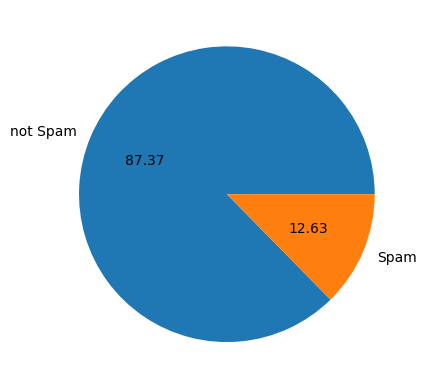

In [13]:
# The code `plt.pie(df['target'].value_counts(), labels = ['not Spam', 'Spam'], autopct='%0.2f')` is creating a pie chart using the values from the 'target' column of the DataFrame 'df'. The pie chart will have two slices labeled 'not Spam' and 'Spam', representing the count of each value in the 'target' column. The `autopct='%0.2f'` parameter formats the percentage values displayed on the chart to have two decimal places. Finally, `plt.show()` is used to display the pie chart.
plt.pie(df['target'].value_counts(), labels = ['not Spam', 'Spam'], autopct='%0.2f')
plt.show()

In [14]:
# This code is adding a new column called 'num_characters' to the DataFrame 'df'. The values in this column are calculated by applying the len() function to each element in the 'text' column of the DataFrame. The resulting values represent the number of characters in each text element.
df['num_characters'] = df['text'].apply(len)
df['num_characters']

0       111
1        29
2       155
3        49
4        61
       ... 
5567    161
5568     37
5569     57
5570    125
5571     26
Name: num_characters, Length: 5169, dtype: int64

In [15]:
# This code is adding a new column called 'num_words' to the DataFrame 'df'. The values in this column are calculated by applying a lambda function to the 'text' column of 'df'. The lambda function uses the 'word_tokenize' function to tokenize each text and then calculates the length of the resulting list of tokens. Finally, the code retrieves the 'num_words' column from 'df'.
df['num_words'] = df['text'].apply(lambda x: len(word_tokenize(x)))
df['num_words']

0       24
1        8
2       37
3       13
4       15
        ..
5567    35
5568     9
5569    15
5570    27
5571     7
Name: num_words, Length: 5169, dtype: int64

In [16]:
# This code is adding a new column called 'num_sentences' to the DataFrame 'df'. The values in this column are calculated by applying a lambda function to the 'text' column of the DataFrame. The lambda function uses the 'sent_tokenize' function to split each text into sentences and then calculates the length of the resulting list of sentences. Finally, the code displays the 'num_sentences' column.
df['num_sentences'] = df['text'].apply(lambda x: len(sent_tokenize(x)))
df['num_sentences']

0       2
1       2
2       2
3       1
4       1
       ..
5567    4
5568    1
5569    2
5570    1
5571    2
Name: num_sentences, Length: 5169, dtype: int64

In [17]:
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [18]:
# The code is filtering the DataFrame `df` to only include rows where the value in the 'target' column is equal to 0. It then selects the columns 'num_characters', 'num_words', and 'num_sentences' from the filtered DataFrame. Finally, it calculates descriptive statistics (such as count, mean, standard deviation, minimum, and maximum) for these selected columns using the `describe()` function.
df[df['target'] == 0][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [19]:
df[df['target'] == 1][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


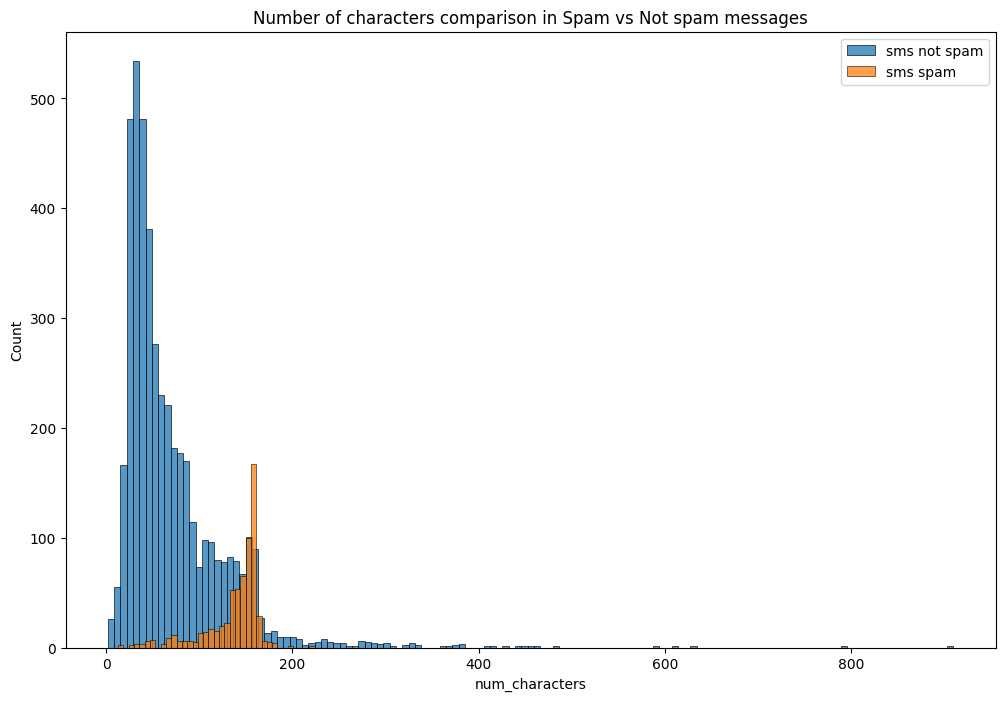

In [20]:
plt.figure(figsize=(12, 8))
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'])
plt.legend(['sms not spam', 'sms spam'])
plt.title('Number of characters comparison in Spam vs Not spam messages')
plt.show()

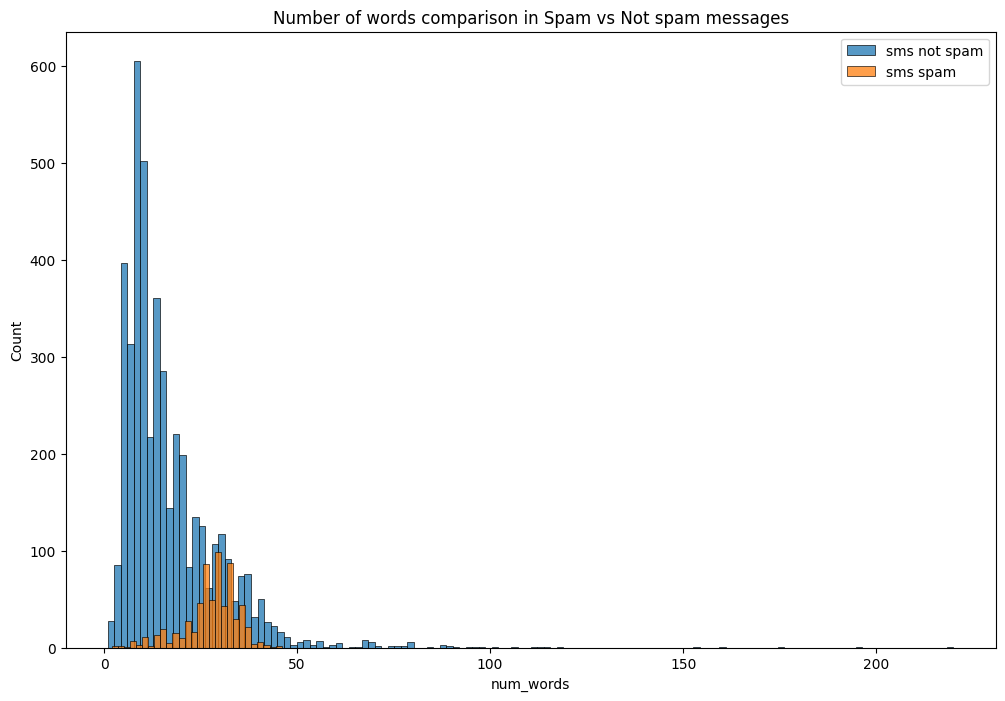

In [21]:
plt.figure(figsize=(12, 8))
sns.histplot(df[df['target'] == 0]['num_words'])
sns.histplot(df[df['target'] == 1]['num_words'])
plt.legend(['sms not spam', 'sms spam'])
plt.title('Number of words comparison in Spam vs Not spam messages')
plt.show()

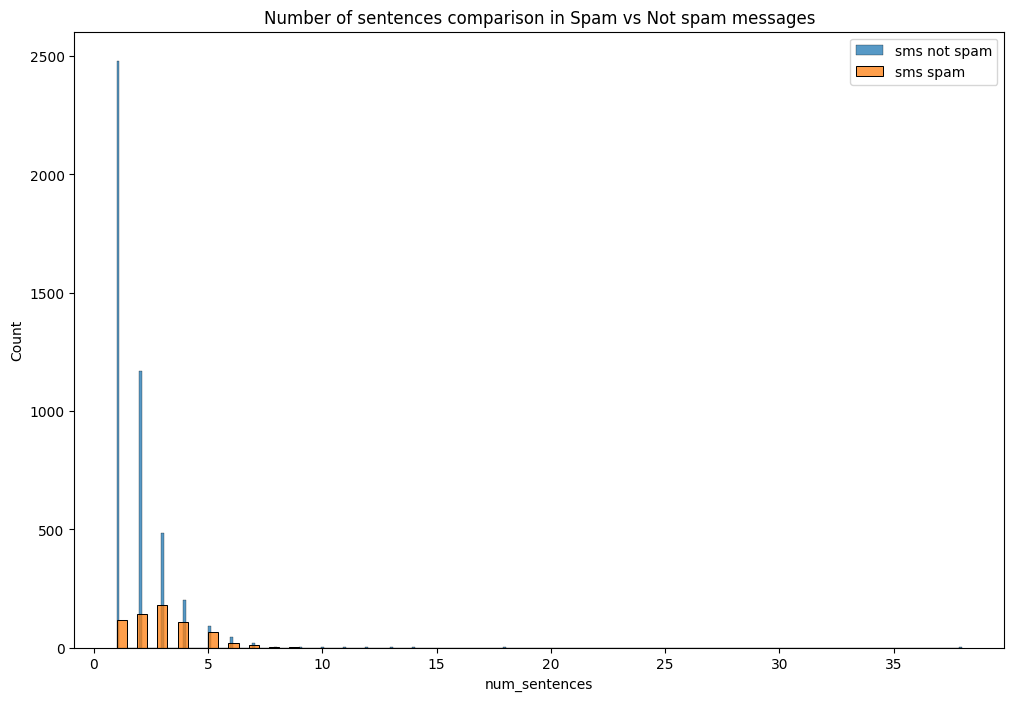

In [22]:
plt.figure(figsize=(12, 8))
sns.histplot(df[df['target'] == 0]['num_sentences'])
sns.histplot(df[df['target'] == 1]['num_sentences'])
plt.legend(['sms not spam', 'sms spam'])
plt.title('Number of sentences comparison in Spam vs Not spam messages')
plt.show()

Visualizing the correlations

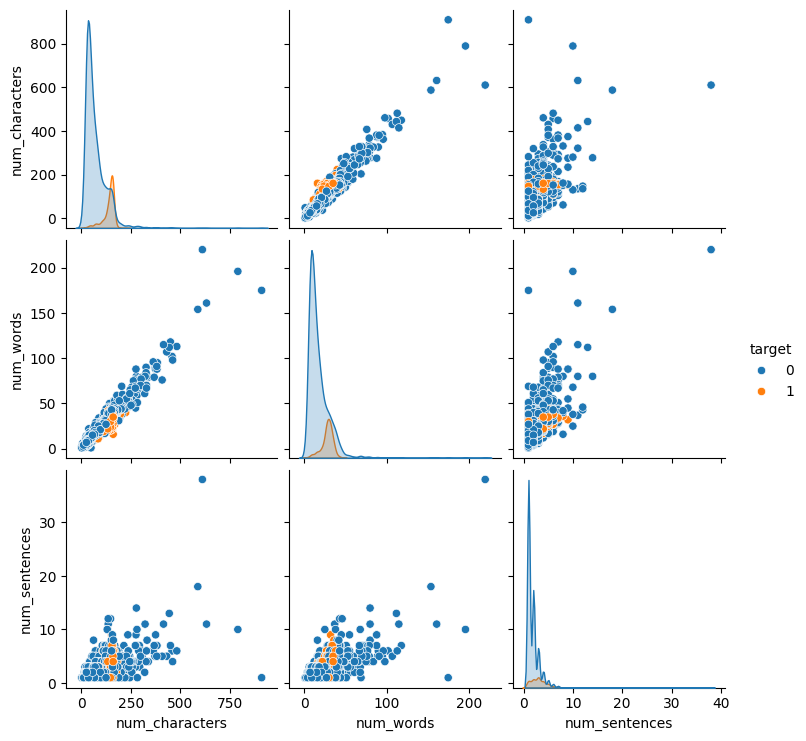

In [23]:
sns.pairplot(df, hue = 'target')

Visualizing the correlation strength using seaborn heatmap

<Axes: >

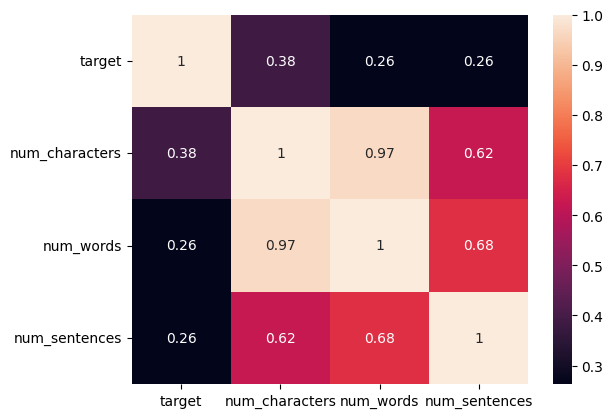

In [25]:
text = df['text']
df.drop(columns='text', inplace=True)
# df.head()
sns.heatmap(df.corr(), annot=True)

Text Preprocessing

In [26]:
def transform_text(text):
    text = text.lower()

    words = word_tokenize(text)

    stopwords_set = set(stopwords.words('english'))

    words = [word for word in words if word not in stopwords_set and word not in string.punctuation]
    
    lemmatizer = WordNetLemmatizer()

    words = [lemmatizer.lemmatize(word) for word in words]
    
    ps = PorterStemmer()
    
    words = [ps.stem(word) for word in words]

    cleaned_text = ' '.join(words)

    return cleaned_text

In [27]:
df['text'] = text

In [28]:
df['transformed_text'] = df['text'].apply(transform_text)
df.head()

,target,num_characters,num_words,num_sentences,text,transformed_text
0,0,111,24,2,"Go until jurong point, crazy.. Available only ...",go jurong point crazi .. avail bugi n great wo...
1,0,29,8,2,Ok lar... Joking wif u oni...,ok lar ... joke wif u oni ...
2,1,155,37,2,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,0,49,13,1,U dun say so early hor... U c already then say...,u dun say earli hor ... u c alreadi say ...
4,0,61,15,1,"Nah I don't think he goes to usf, he lives aro...",nah n't think go usf life around though


In [29]:
wc = WordCloud(width= 500, height=500, min_font_size=12,background_color='white')

In [30]:
wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep = ""))

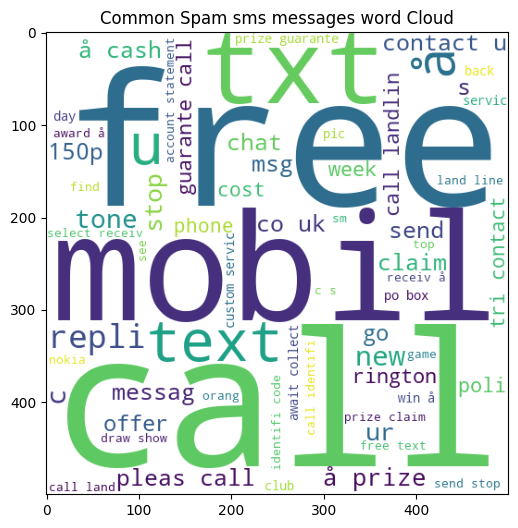

In [31]:
plt.figure(figsize=(15, 6))
plt.title('Common Spam sms messages word Cloud')
plt.imshow(wc)

In [32]:
wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep = ""))

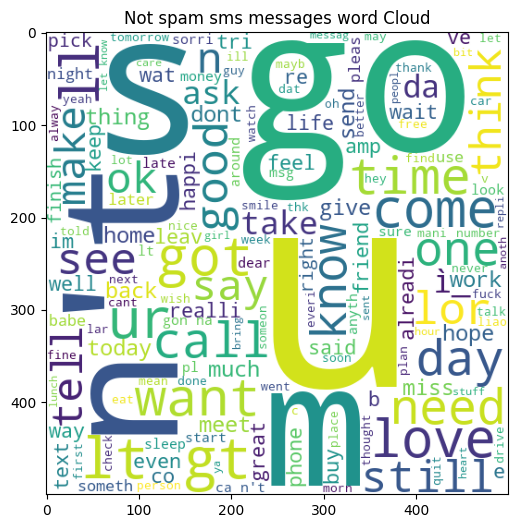

In [33]:
plt.figure(figsize=(15, 6))
plt.title('Not spam sms messages word Cloud')
plt.imshow(wc)

In [34]:
spam_messages = {}
for line in df[df['target']==1]['transformed_text'].tolist():
    line = line.split()
    for word in line:
        if word not in spam_messages:
            spam_messages[word] = 1
        else:
            spam_messages[word] +=1
spam_messages = dict(sorted(spam_messages.items(), key=lambda item: item[1], reverse=True))
top_50_words = dict(list(spam_messages.items())[:50])
top_50_words

{'call': 320,
 'free': 191,
 '2': 155,
 'txt': 141,
 'u': 126,
 'text': 122,
 'ur': 119,
 'mobil': 114,
 'stop': 104,
 'repli': 103,
 'claim': 98,
 '4': 97,
 'prize': 82,
 'c': 80,
 'get': 74,
 'new': 64,
 'servic': 64,
 'tone': 63,
 'send': 60,
 "'s": 59,
 'urgent': 57,
 'nokia': 57,
 'contact': 56,
 'award': 55,
 'phone': 52,
 'cash': 51,
 'pleas': 51,
 'week': 49,
 'win': 48,
 'collect': 45,
 'min': 45,
 'custom': 42,
 'messag': 42,
 'guarante': 42,
 'per': 41,
 'chat': 38,
 'tri': 37,
 'msg': 35,
 'draw': 35,
 'number': 35,
 'show': 33,
 'today': 33,
 'offer': 33,
 'line': 33,
 'go': 32,
 'receiv': 31,
 'want': 31,
 'latest': 30,
 'rington': 30,
 'landlin': 30}

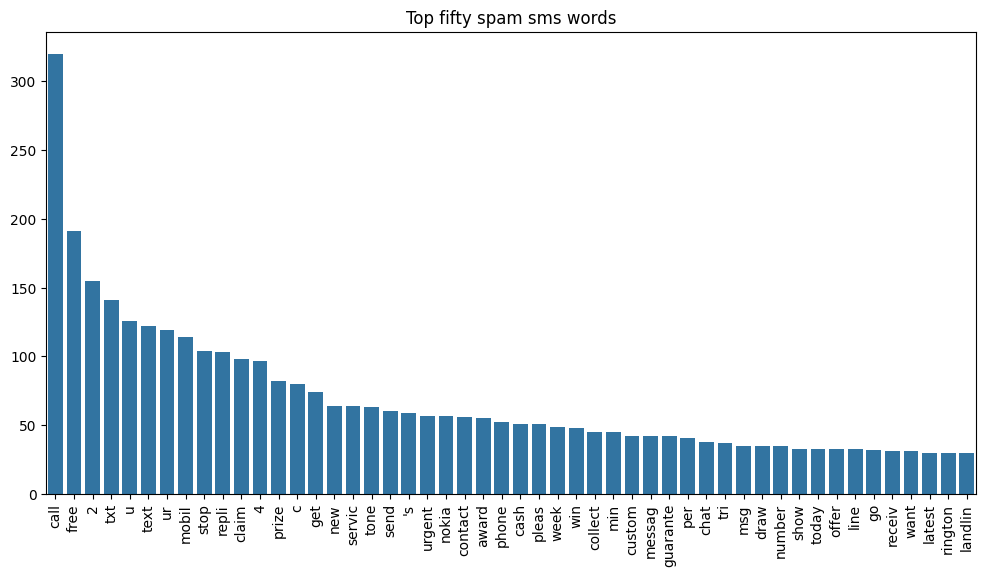

In [35]:
plt.figure(figsize=(12,6))
sns.barplot(top_50_words)
plt.xticks(rotation = 90)
plt.title("Top fifty spam sms words")
plt.show()

In [36]:
df.head()

,target,num_characters,num_words,num_sentences,text,transformed_text
0,0,111,24,2,"Go until jurong point, crazy.. Available only ...",go jurong point crazi .. avail bugi n great wo...
1,0,29,8,2,Ok lar... Joking wif u oni...,ok lar ... joke wif u oni ...
2,1,155,37,2,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,0,49,13,1,U dun say so early hor... U c already then say...,u dun say earli hor ... u c alreadi say ...
4,0,61,15,1,"Nah I don't think he goes to usf, he lives aro...",nah n't think go usf life around though


In [37]:
tfidf = TfidfVectorizer(max_features= 3000)

In [38]:
X = tfidf.fit_transform(df['transformed_text']).toarray()
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [39]:
X.shape

(5169, 3000)

In [40]:
y = df['target'].values
y

array([0, 0, 1, ..., 0, 0, 0])

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [42]:
gaussian = GaussianNB()
multinomial = MultinomialNB()
bernoulli = BernoulliNB()


In [43]:
gaussian.fit(X_train, y_train)
gaussian_predict = gaussian.predict(X_test)
# print(accuracy_score(y_test, gaussian_predict))
print(confusion_matrix(y_test, gaussian_predict))
# print('Pre'precision_score(y_test, gaussian_predict))
print("Classification report GaussianNB\n", classification_report(y_test, gaussian_predict))

[[773 116]
 [ 24 121]]
Classification report GaussianNB
               precision    recall  f1-score   support

           0       0.97      0.87      0.92       889
           1       0.51      0.83      0.63       145

    accuracy                           0.86      1034
   macro avg       0.74      0.85      0.78      1034
weighted avg       0.91      0.86      0.88      1034



In [ ]:
multinomial.fit(X_train, y_train)
multinomial_predict = multinomial.predict(X_test)
# print(accuracy_score(y_test, multinomial_predict))
print(confusion_matrix(y_test, multinomial_predict))
# print('Pre'precision_score(y_test, multinomial_predict))
print("Classification report multinomialNB\n", classification_report(y_test, multinomial_predict))

[[888   1]
 [ 24 121]]
Classification report multinomialNB
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       889
           1       0.99      0.83      0.91       145

    accuracy                           0.98      1034
   macro avg       0.98      0.92      0.95      1034
weighted avg       0.98      0.98      0.97      1034



In [44]:
bernoulli.fit(X_train, y_train)
bernoulli_predict = bernoulli.predict(X_test)
# print(accuracy_score(y_test, bernoulli_predict))
print(confusion_matrix(y_test, bernoulli_predict))
# print('Pre'precision_score(y_test, bernoulli_predict))
print("Classification report bernoulliNB\n", classification_report(y_test, bernoulli_predict))

[[886   3]
 [ 19 126]]
Classification report bernoulliNB
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       889
           1       0.98      0.87      0.92       145

    accuracy                           0.98      1034
   macro avg       0.98      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034



In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [61]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)

In [47]:

clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt
}

In [48]:
def train_classifier(name, clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(f"Classification report of {name}\n", classification_report(y_test, y_pred))
    return accuracy, precision, recall

In [49]:
accuracy_scores = []
precision_scores = []
recall_scores = []

for name, clf in clfs.items():
    
    current_accuracy, current_precision, current_recall = train_classifier(name, clf, X_train, y_train, X_test, y_test)
    
    # print("For ", name)
    # print("Accuracy - ", current_accuracy)
    # print("Precision - ", current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    recall_scores.append(current_recall)

Classification report of SVC
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       889
           1       0.95      0.89      0.92       145

    accuracy                           0.98      1034
   macro avg       0.97      0.94      0.95      1034
weighted avg       0.98      0.98      0.98      1034

Classification report of KN
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       889
           1       1.00      0.30      0.47       145

    accuracy                           0.90      1034
   macro avg       0.95      0.65      0.71      1034
weighted avg       0.91      0.90      0.88      1034

Classification report of NB
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       889
           1       0.99      0.83      0.91       145

    accuracy                           0.98      1034
   macro avg       0.98      0.92      0

In [50]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy': accuracy_scores,'Precision':precision_scores, 'Recall': recall_scores}).sort_values('Precision', ascending=False)
performance_df

,Algorithm,Accuracy,Precision,Recall
1,KN,0.902321,1.000000,0.303448
5,RF,0.983559,1.000000,0.882759
8,ETC,0.981625,1.000000,0.868966
2,NB,0.975822,0.991803,0.834483
9,GBDT,0.955513,0.980583,0.696552
0,SVC,0.977756,0.948529,0.889655
6,AdaBoost,0.975822,0.941176,0.882759
7,BgC,0.972921,0.920863,0.882759
4,LR,0.959381,0.912000,0.786207
3,DT,0.944874,0.860656,0.724138


Random Forest Classifer is the most precise classifier for this problem and has an accuracy over 98%, this is the most suitable classifier for this problem, as this is an unbalanced dataset, so the accuracy doesn't matter much.

In [65]:
import pickle
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
pickle.dump(rfc, open('model.pkl', 'wb'))

In [62]:
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=2)

In [64]:
t = transform_text('Hello you just won 1000, call now to get your prize')
t
t =tfidf.transform([t])
pred= rfc.predict(t)
pred


array([1])